# Reference


Tensorflow
1. https://www.tensorflow.org/tutorials/images/classification
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

Keras (https://keras.io/api/)
1. https://keras.io/examples/vision/image_classification_from_scratch/
2. https://keras.io/guides/preprocessing_layers/

Data_loading >> https://keras.io/api/data_loading/image/
1. image_dataset_from_directory function = Generates a tf.data.Dataset from image files in a directory. (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
2. load_img function = Loads an image into PIL format.
3. img_to_array function = Converts a PIL Image instance to a Numpy array.
4. save_img function = Saves an image stored as a Numpy array to a path or file object.


Keras models accept three types of inputs:
- NumPy arrays
- TensorFlow Dataset objects
- Python generators

## 1.Setup

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d22ccc0a-c0e7-fcbc-5708-598fb44d6e0f)


In [ ]:
import sys
print(f"Python {sys.version}\n")

import numpy as np
print(f"Numpy {np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detected {len(gpus)} GPU(s):")
for i,gpu in enumerate(gpus):
  print(f"...GPU No.{i} : Name = {gpu.name}, Type = {gpu.device_type}")

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

Numpy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
...GPU No.0 : Name = /physical_device:GPU:0, Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
seed = np.random.randint(1000,10000)

In [ ]:
batch_size = 32
image_size = (224, 224)

## 2.Load data using a Keras utility

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class.
# Otherwise, the directory structure is ignored.
train_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/train_ds"
test_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/test_ds"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/gdrive/MyDrive/DADS_7202/dataset/train_ds",
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=1234,
  validation_split=0.2,
  subset="training",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 284 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=1234,
  validation_split=0.2,
  subset="validation",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 70 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=1234,
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 80 files belonging to 4 classes.


## 2.1 Explore train_ds

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['apple', 'huawei', 'oppo', 'samsung']


In [ ]:
# check dtypes and shape
for images, labels in train_ds.take(1):
  print(f"image = {images.dtype}, shape = {images.shape}")
  print(f"labels = {labels.dtype}, shape = {labels.shape}")
  break

image = <dtype: 'float32'>, shape = (32, 224, 224, 3)
labels = <dtype: 'int32'>, shape = (32,)


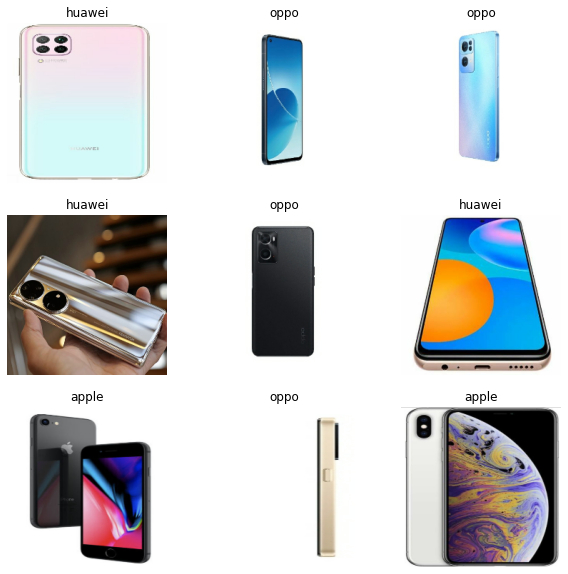

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): 
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 3.1 Data Augment



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=1234),
                                         tf.keras.layers.RandomRotation(0.2),
                                         ])


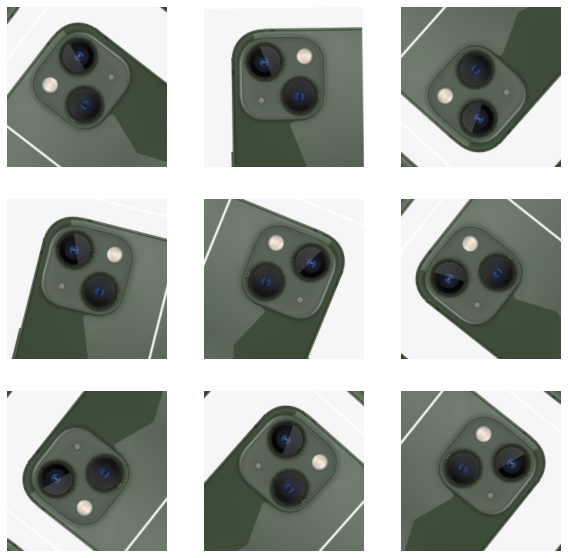

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

## 4.Load the pretrained model (only the feature extractor)

In [ ]:
img_w,img_h = 224,224 
mobilenet = base_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3),
                                                  include_top=False,
                                                  weights='imagenet')


base_model.trainable = False
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

### 4.1 Tuning Feature Extraction layer
---
**จุดที่ Fine Tuning ได้**
* รูปแบบ Data Aug layer
* Feature extraction
  - แก้ freeze ของ pre-train
  - เพิ่ม Convolution / pooling ต่อจาก pre-train
* เพิ่ม/ปรับ Classifier layer

In [ ]:
mobilenet.trainable = True
for i,layer in enumerate(mobilenet.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = True
Layer 1: name = conv1 , trainable = True
Layer 2: name = conv1_bn , trainable = True
Layer 3: name = conv1_relu , trainable = True
Layer 4: name = conv_dw_1 , trainable = True
Layer 5: name = conv_dw_1_bn , trainable = True
Layer 6: name = conv_dw_1_relu , trainable = True
Layer 7: name = conv_pw_1 , trainable = True
Layer 8: name = conv_pw_1_bn , trainable = True
Layer 9: name = conv_pw_1_relu , trainable = True
Layer 10: name = conv_pad_2 , trainable = True
Layer 11: name = conv_dw_2 , trainable = True
Layer 12: name = conv_dw_2_bn , trainable = True
Layer 13: name = conv_dw_2_relu , trainable = True
Layer 14: name = conv_pw_2 , trainable = True
Layer 15: name = conv_pw_2_bn , trainable = True
Layer 16: name = conv_pw_2_relu , trainable = True
Layer 17: name = conv_dw_3 , trainable = True
Layer 18: name = conv_dw_3_bn , trainable = True
Layer 19: name = conv_dw_3_relu , trainable = True
Layer 20: name = conv_pw_3 , trainable = True
Layer 21:

#4.2 Construct

In [ ]:
# Input Layer

inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augment & Feature Extraction
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x) 

x = tf.keras.layers.Flatten()(x)
# Classifier
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output Layer
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                             

# 5.Compile and train the model


In [ ]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) , 
                       loss="sparse_categorical_crossentropy",
                       metrics=['acc'] 
                     )

# 6.Train the model on train set


In [ ]:
#checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
checkpoint_filepath = "bestmodel_epoch.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True, 
                                                               monitor='val_acc', 
                                                               mode='max',
                                                               save_best_only=True)

In [ ]:
%%time
history = model.fit(train_dataset,
                    batch_size = batch_size,
                    epochs=100, verbose=1,
                    validation_data=validation_dataset,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/100
9/9 [==============================] - 33s 3s/step - loss: 4.7373 - acc: 0.3908 - val_loss: 2.2466 - val_acc: 0.5000
Epoch 2/100
9/9 [==============================] - 3s 253ms/step - loss: 1.5279 - acc: 0.6549 - val_loss: 1.9586 - val_acc: 0.4714
Epoch 3/100
9/9 [==============================] - 3s 294ms/step - loss: 1.1546 - acc: 0.6796 - val_loss: 0.9776 - val_acc: 0.6429
Epoch 4/100
9/9 [==============================] - 3s 289ms/step - loss: 0.7576 - acc: 0.7746 - val_loss: 1.3700 - val_acc: 0.6857
Epoch 5/100
9/9 [==============================] - 4s 327ms/step - loss: 0.6590 - acc: 0.7887 - val_loss: 1.2256 - val_acc: 0.6857
Epoch 6/100
9/9 [==============================] - 5s 316ms/step - loss: 0.4398 - acc: 0.8592 - val_loss: 0.9408 - val_acc: 0.7429
Epoch 7/100
9/9 [==============================] - 3s 257ms/step - loss: 0.4077 - acc: 0.8662 - val_loss: 0.9392 - val_acc: 0.7429
Epoch 8/100
9/9 [==============================] - 3s 255ms/step - loss: 0.3611 - acc

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
model.load_weights('bestmodel_epoch.hdf5')

In [ ]:
results_val = model.evaluate(validation_dataset)
print( f"{model.metrics_names}: {results_val}" )

3/3 [==============================] - 0s 24ms/step - loss: 0.2554 - acc: 0.9571
['loss', 'acc']: [0.2553905248641968, 0.9571428298950195]


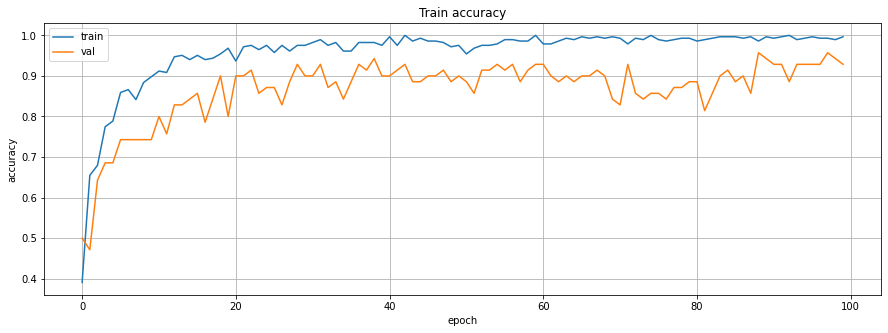

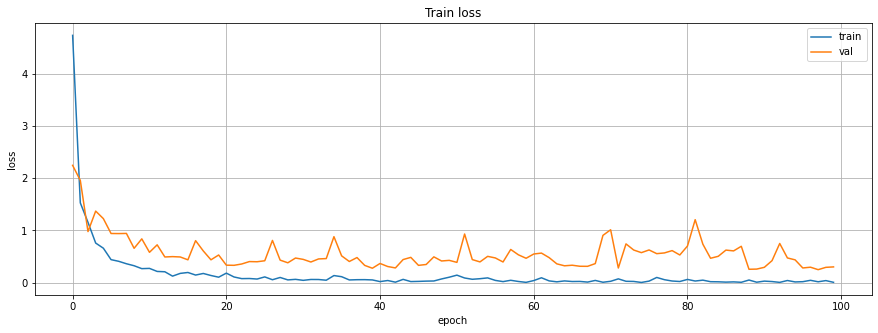

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 7.Evaluate the model & Inference

In [ ]:
results_test_ds = model.evaluate(test_dataset)
print( f"{model.metrics_names}: {results_test_ds}" )

3/3 [==============================] - 25s 277ms/step - loss: 0.5270 - acc: 0.9125
['loss', 'acc']: [0.5269771814346313, 0.9125000238418579]


In [ ]:
# Retrieve a batch of images from the test set
image_batch,label_batch  = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) # Returns predictions for a single batch of samples.

In [ ]:
print (type(image_batch),", dtype=",image_batch.dtype,", shape=",image_batch.shape)
print (type(label_batch ),", dtype=",label_batch .dtype,", shape=",label_batch .shape)

<class 'numpy.ndarray'> , dtype= float32 , shape= (32, 224, 224, 3)
<class 'numpy.ndarray'> , dtype= int32 , shape= (32,)


In [ ]:
predictions

In [ ]:
predictions.shape

(32, 4)

In [ ]:
i=0

print( f"type={type(predictions)}\ndtype={predictions.dtype}\nshape={predictions[i].shape}" )
print( f"value={predictions[i]}" )
print( f"np.argmax(y_pred)={class_names[np.argmax(predictions[i])]}" )

type=<class 'numpy.ndarray'>
dtype=float32
shape=(4,)
value=[4.2581597e-08 1.0000000e+00 5.5749017e-12 5.0317613e-08]
np.argmax(y_pred)=huawei


In [ ]:
for i in range(9):
  print("No.", i, 'Labels:', class_names[label_batch[i]], 'Predictions:', class_names[np.argmax(predictions[i])])

No. 0 Labels: huawei Predictions: huawei
No. 1 Labels: samsung Predictions: samsung
No. 2 Labels: huawei Predictions: huawei
No. 3 Labels: huawei Predictions: huawei
No. 4 Labels: samsung Predictions: samsung
No. 5 Labels: apple Predictions: samsung
No. 6 Labels: oppo Predictions: oppo
No. 7 Labels: huawei Predictions: huawei
No. 8 Labels: samsung Predictions: samsung


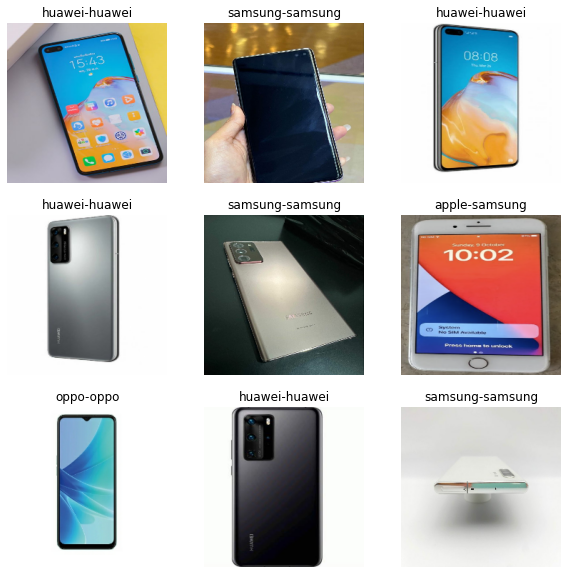

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]] + "-" +class_names[np.argmax(predictions[i])] )  # y_test y_pred
  plt.axis("off")